# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)

# HW3: REINFORCE with continous action space in MountainCarContinous
> - Full Name: **Ayeen Poostforoushan**
> - Student ID: **401105742**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **MountainCarContinuous-v0** environment. The objective is to evaluate the performance and stability of REINFORCE in a continuous action space.

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 80 points
- Conceptual Understanding: 20 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [1]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [2]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [3]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                mean, _ = policy_net(state_tensor)
                action = mean.item()
                state, _, terminated, truncated, _ = env.step([action])

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment (10 points)

Initialize MountainCarContinuous Environment and Display State & Action Spaces

In [4]:
# Create the MountainCarContinuous environment
env = gym.make("MountainCarContinuous-v0")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Box(-1.0, 1.0, (1,), float32)


**Question 1: (5 points)**

How are the observation and action spaces defined in the MountainCarContinuous environment?

.....</br>
.....</br>


In [5]:
print(env.observation_space.shape[0])
print(env.action_space.shape[0])

2
1


Define a Random Policy for Action Selection  

In [6]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values, nan = torch.rand(self.action_space_n), np.nan
        return action_values, nan

Visualize the random policy.

In [7]:
random_policy = RandomPolicy(env.action_space.shape[0])

# record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), random_policy, "Video_MountainCarContinuous_random_policy")

**Question 2: (5 points)**

How could an agent reach the goal in the MountainCarContinuous environment while using the least amount of energy? Explain a scenario describing the agent's behavior during an episode with most optimal policy.

.....</br>
.....</br>


# Agent with REINFORCE in a continuous action space in MountainCarContinuous-v0 (80 points)

### Policy Network Definition (10 points)

In continuous action spaces, instead of choosing from a discrete set of actions, the policy network learns a Gaussian distribution
$\pi_\theta(a|s)$ over possible actions. The agent then samples an action from this distribution:

$$a \sim \mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$$

where:

- $\mu_\theta(s)$ is the mean of the action distribution.
- $\sigma_\theta(s)$ is the standard deviation (exploration factor).

The network is trained using policy gradients, reinforcing actions that lead to better rewards.


In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean_head = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim), requires_grad=True)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x)) + x
        mean = self.mean_head(x)
        std = torch.exp(self.log_std)
        return mean, std

    def get_action(self, state):
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        # Sample a raw action
        raw_action = dist.sample()
        log_prob = dist.log_prob(raw_action)
        # If needed, apply tanh to bound the action in [-1, 1]
        final_action = torch.tanh(raw_action)
        return final_action, log_prob

### Computing Discounted Returns (15 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [9]:
# TODO: Implement the function to compute discounted returns
def compute_returns(trajectory, gamma=0.99):
    discounted_returns = []
    discounted_sum = 0
    for _, _, reward, _ in reversed(trajectory):
        discounted_sum = reward + gamma * discounted_sum
        discounted_returns.insert(0, discounted_sum)
    return discounted_returns

### Implementing the REINFORCE Algorithm in continuous action space (45 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [10]:
def reinforce(env, policy_net: PolicyNetwork, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    for episode in range(num_episodes):
        state = env.reset()
        trajectory = []
        while True:
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            action, log_prob = policy_net.get_action(state_tensor)
            next_state, reward, truncated, terminated = env.step(action.cpu().numpy())

            trajectory.append((state, action, reward, log_prob))
            if truncated or terminated:
                break
            state = next_state

        returns = compute_returns(trajectory, gamma)

        # loss = torch.tensor(0, dtype=torch.float32).to(DEVICE)
        # for (state, action, _, log_prob), G in zip(trajectory, returns):
        #     loss -= G * log_prob

        log_probs = torch.stack([log_prob for (_, _, _, log_prob) in trajectory])
        returns_tensor = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
        loss = -torch.sum(log_probs * returns_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_episode_reward = sum([reward for _, _, reward, _ in trajectory])
        rewards_per_episode.append(total_episode_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {total_episode_reward}")

    return rewards_per_episode

### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [11]:
# TODO: Define all necessary hyperparameters
INPUT_DIM =         env.observation_space.shape[0]
OUTPUT_DIM =        env.action_space.shape[0]
LEARNING_RATE =     0.0015
DISCOUNT_FACTOR =   0.97
NUM_EPISODES =      1500

# Initialize Policy
policy = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)

# Optimizer
optimizer= optim.Adam(policy.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE Algorithm for Continuous Action Space:")
rewards = reinforce(env, policy, optimizer, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

Training REINFORCE Algorithm for Continuous Action Space:
Episode 50, Reward: -86.08761488433312
Episode 100, Reward: -91.29465228709478
Episode 150, Reward: -57.64553759989457
Episode 200, Reward: -54.0889302118556
Episode 250, Reward: -69.59339425396031
Episode 300, Reward: -91.78998507841953
Episode 350, Reward: -83.55974584342167
Episode 400, Reward: -95.94071600248078
Episode 450, Reward: -64.34867439066264
Episode 500, Reward: -44.04764839251535
Episode 550, Reward: -47.753641418364005
Episode 600, Reward: -49.38859093378547
Episode 650, Reward: -75.14572504556327
Episode 700, Reward: -56.129016066109436
Episode 750, Reward: -72.17390197314391
Episode 800, Reward: -58.90602396191454
Episode 850, Reward: -42.882989610020914
Episode 900, Reward: -40.9242385807609
Episode 950, Reward: -39.65291485966142
Episode 1000, Reward: -39.15755280046798
Episode 1050, Reward: -41.342647332058334
Episode 1100, Reward: -41.70655094605849
Episode 1150, Reward: -40.71144548143545
Episode 1200, Rew

# Results (10 points)

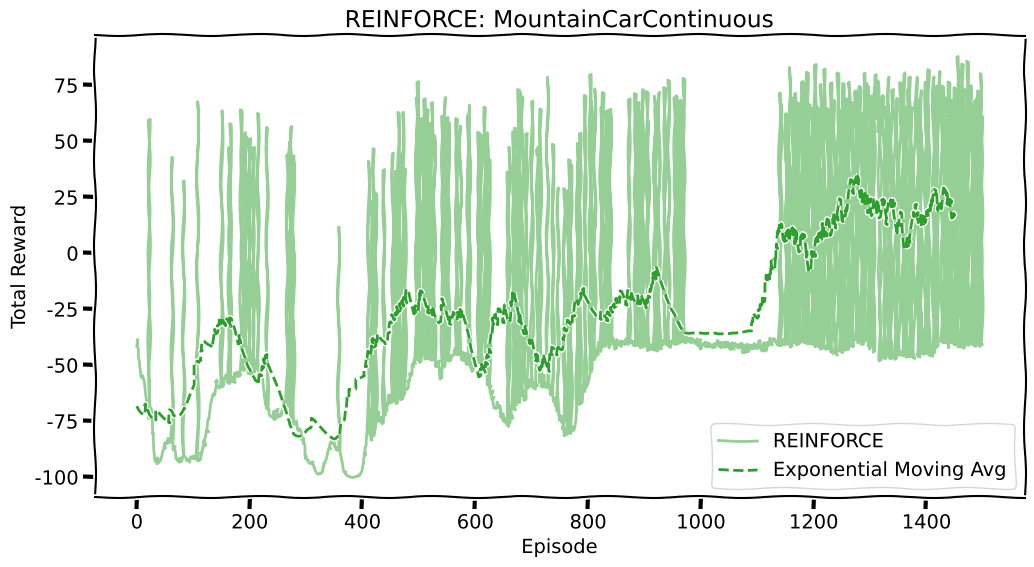

In [12]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards, label="REINFORCE", alpha=0.5, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards, window_size), label="Exponential Moving Avg", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: MountainCarContinuous")
plt.show()

In [13]:
mean_reward, std_reward = np.mean(rewards), np.std(rewards)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = -33.69 +/- 52.4040


**Question 3: (10 points)**

What strategies can be employed to reduce catastrophic forgetting in continuous action space environments like MountainCarContinuous?
</br>(Hint: experience replay or target networks)

.....</br>
.....</br>


# Simulation

In [15]:
# Record the simulation using the optimal policy
record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), policy, "Video_MountainCarContinuous_REINFORCE")